### Simulation with full account of volume adjustment

In [1]:
import re
import collections as col
import cPickle as pkl
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
import platform
if platform.system()=="Windows":
    files = !dir ..\..\results\vol*
else:
    files = !ls ../../results/vol*

In [5]:
filepaths = {}
for file in files:
    match = re.search(r'from (\w+)', file)
    if match:
        if platform.system()=="Windows":
            filepaths[int(match.group(1).zfill(4))] = r"..\\..\\results\\" + file[file.index("polyphasic"):]
            # because the output of dir is more complex than that of ls
        else:
            filepaths[int(match.group(1).zfill(4))] = file

In [7]:
for time in filepaths:
    print time,
    #replace(filepaths[time], "_numpypy.multiarray", "numpy.core.multiarray")  # takes time, run only once

 0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


In [8]:
results = {}
proteome = {}
for time in filepaths:
    print time, filepaths[time]
    results[time] = pkl.load(open(filepaths[time]))
    proteome[time] = {key: results[time]['proteome'][key] for key in results[time]['proteome'] 
                     if results[time]['proteome'][key] > 1e-1}

0 ../../results/volume-adjusted polyphasic cell cycle from 0 to 300, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160906_1519_2100s.p
2400 ../../results/volume-adjusted polyphasic cell cycle from 2400 to 2700, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160906_2009_2100s.p
3300 ../../results/volume-adjusted polyphasic cell cycle from 3300 to 3600, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160906_2154_2100s.p
1800 ../../results/volume-adjusted polyphasic cell cycle from 1800 to 2100, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20160906_1850_2100s.p
300 ../../results/volume-adjusted polyphasic cell cycle from 300 to 600, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates 

In [9]:
transcriptomes_dict = col.OrderedDict(sorted(
        pkl.load((open('../../parameters/transcriptome_time_dependent.p'))).items()))

In [10]:
transcriptome_df = pd.DataFrame(transcriptomes_dict).transpose()
del transcriptome_df[0]
transcriptome_df.index = np.arange(0, 3601, 300)
transcriptome_df

,Q0010,Q0017,Q0032,Q0045,Q0050,Q0055,Q0060,Q0065,Q0070,Q0075,...,YPR196W,YPR197C,YPR198W,YPR199C,YPR200C,YPR201W,YPR202W,YPR203W,YPR204C-A,YPR204W
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
600,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
900,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,0,0,0,0
1200,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
1500,0,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,0,0,0
1800,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,0,0,0,0,0,0
2100,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,0,0,0,0
2400,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2700,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [11]:
translation_rate_shortlist = {}
genes = transcriptomes_dict[0].keys()[1:]

for gene in genes:
    translation_rate_shortlist[gene] = []
    for time in np.arange(0, 3600, 300):
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-301])/300.
        else:
            rate = 0.
        translation_rate_shortlist[gene].append(rate)

translation_ratedf = pd.DataFrame(translation_rate_shortlist, index=np.arange(0, 3600, 300))

In [12]:
translation_rate_per_mrna = translation_ratedf / transcriptome_df
translation_rate_per_mrna.dropna(axis=1, how='all', inplace=True)
translation_rate_per_mrna

,YAL001C,YAL002W,YAL003W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,...,YPR187W,YPR188C,YPR189W,YPR190C,YPR191W,YPR192W,YPR196W,YPR198W,YPR199C,YPR200C
0,NaN,0.033333,0.249608,0.0,0.110000,0.160000,0.063333,NaN,NaN,0.210476,...,0.147333,0.096667,0.080000,0.100000,0.116667,NaN,NaN,NaN,NaN,NaN
300,0.063333,NaN,0.261282,0.0,0.113333,0.153333,NaN,NaN,NaN,0.218596,...,0.145000,0.093333,0.086667,0.096667,0.123333,NaN,NaN,NaN,NaN,NaN
600,0.033333,0.013333,0.149375,0.0,0.061667,0.085833,0.030000,NaN,0.023333,0.116667,...,0.077436,0.056667,0.033333,0.041667,0.060000,NaN,NaN,0.043333,NaN,0.0
900,0.023333,0.023333,0.150784,0.0,0.062667,0.085556,0.036667,0.040000,0.026667,0.119454,...,0.079487,0.053333,0.053333,0.036667,0.046667,NaN,NaN,0.051667,0.010000,NaN
1200,0.026667,0.013333,0.149412,0.0,0.072667,0.088333,0.036667,NaN,0.030000,0.121515,...,0.077111,0.051111,0.046667,0.047333,0.056667,NaN,NaN,0.056667,0.010000,0.0
1500,0.023333,0.005000,0.103600,0.0,0.042917,0.060000,0.023333,NaN,0.033333,0.084198,...,0.051905,0.032500,0.014167,0.021111,0.048889,0.0,0.0,0.021667,0.003333,NaN
1800,0.008333,0.016667,0.106633,0.0,0.039583,0.053333,0.014667,0.020000,0.021667,0.084783,...,0.052963,0.041111,0.023333,0.025556,0.041667,NaN,NaN,0.026667,0.006667,NaN
2100,0.026667,0.011111,0.110128,0.0,0.036250,0.060000,0.018333,0.016667,0.016667,0.086704,...,0.052857,0.036667,0.030000,0.025714,0.044444,NaN,NaN,0.038333,0.010000,NaN
2400,0.053333,0.010000,0.205062,0.0,0.091667,0.106667,0.044444,NaN,NaN,0.168081,...,0.111515,0.086667,0.061667,0.060000,0.093333,NaN,NaN,0.063333,0.043333,NaN
2700,0.063333,0.010000,0.205674,0.0,0.090000,0.123333,0.053333,NaN,0.073333,0.167073,...,0.109394,0.078333,0.050000,0.061667,0.103333,NaN,NaN,0.080000,0.026667,NaN


In [13]:
translation_rate_per_mrna.mean(axis=1, skipna=True)

0       0.094108
300     0.094894
600     0.040882
900     0.042421
1200    0.043531
1500    0.027400
1800    0.027290
2100    0.027922
2400    0.066360
2700    0.066242
3000    0.089612
3300    0.062582
3600         NaN
dtype: float64

In [14]:
import matplotlib.collections as collections

In [15]:
t = np.arange(0.0, 61.0, 2.5)

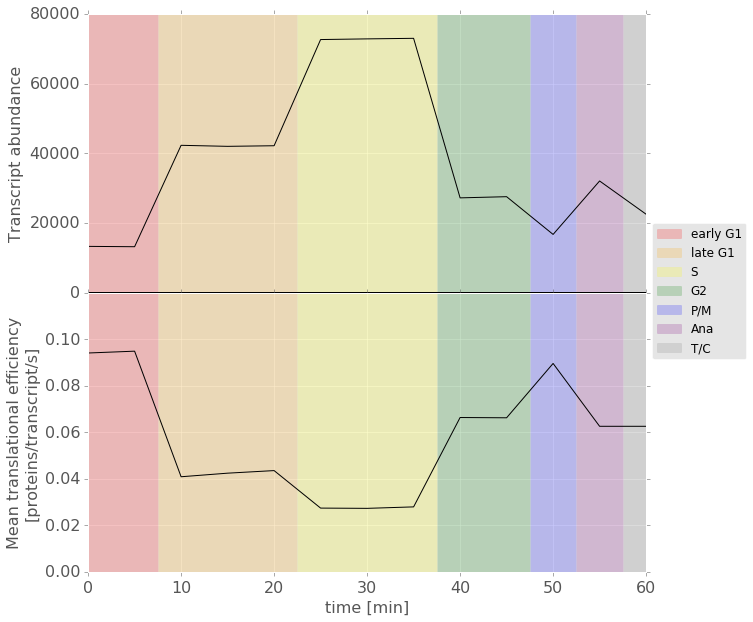

In [17]:
plt.rcParams['figure.figsize'] = (10, 10)

# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5)
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]

x2 = x1
# values from simulation
y2 = translation_rate_per_mrna.mean(axis=1, skipna=True).values[:-1]
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0), y2)

#######################################################################################################################
# Two subplots sharing both x/y axes
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=16)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 7.6, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t > 57.4, facecolor='grey', alpha=0.2)
ax.add_collection(collection)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='early G1', alpha=0.2)
orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=0.2)
yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=0.2)
green_patch = mpatches.Patch(color='green', label='G2', alpha=0.2)
blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=0.2)
purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=0.2)
grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=0.2)

plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch, grey_patch], 
           loc='lower left', bbox_to_anchor=(1, 0.74), fancybox=True, framealpha=1.0)

# plt.text(1.0, 5000, "early G1", fontsize=16, weight="bold")

#######################################################################################################################
ax2.plot(x2, y2, color='black')

ax = ax2
pos = np.arange(0.0, 0.11, 0.02)
ax.set_yticks(pos)
ax.set_yticklabels(["%.2f" % round(p,2) for p in pos], fontsize=16)
ax.set_ylabel("Mean translational efficiency\n[proteins/transcript/s]", fontsize=16)
ax.set_xlabel("time [min]", fontsize=16)


collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=t < 7.6, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=t > 57.4, facecolor='grey', alpha=0.2)
ax.add_collection(collection)

plt.ylim([0, 0.12])

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

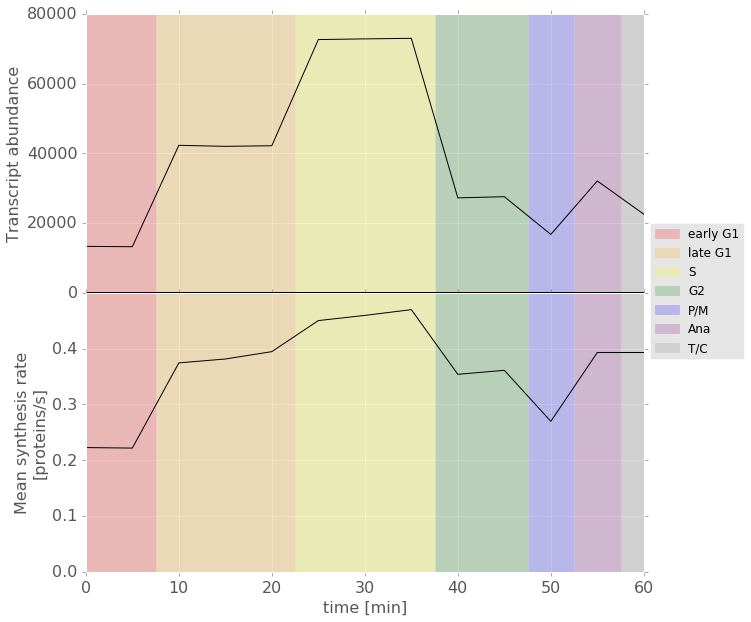

In [27]:
plt.rcParams['figure.figsize'] = (10, 10)

# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5)
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]

x2 = x1
# values from simulation
y2 = translation_ratedf.mean(axis=1, skipna=True).values
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0), y2)

#######################################################################################################################
# Two subplots sharing both x/y axes
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=16)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 7.6, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t > 57.4, facecolor='grey', alpha=0.2)
ax.add_collection(collection)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='early G1', alpha=0.2)
orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=0.2)
yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=0.2)
green_patch = mpatches.Patch(color='green', label='G2', alpha=0.2)
blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=0.2)
purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=0.2)
grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=0.2)

plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch, grey_patch], 
           loc='lower left', bbox_to_anchor=(1, 0.74), fancybox=True, framealpha=1.0)

# plt.text(1.0, 5000, "early G1", fontsize=16, weight="bold")

#######################################################################################################################
ax2.plot(x2, y2, color='black')

ymax = 0.5

ax = ax2
pos = np.arange(0.0, ymax, 0.1)
ax.set_yticks(pos)
ax.set_yticklabels(["%.1f" % round(p,1) for p in pos], fontsize=16)
ax.set_ylabel("Mean synthesis rate\n[proteins/s]", fontsize=16)
ax.set_xlabel("time [min]", fontsize=16)


collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=t < 7.6, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=t > 57.4, facecolor='grey', alpha=0.2)
ax.add_collection(collection)

plt.ylim([0, ymax])

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()